### Initialize notebook

In [1]:
#!/home/akhanal1/Spring2018/pl-env/bin/python3.5
# Torch imports

import os
import sys
sys.path.append('/home/ak/PycharmProjects/ature')
os.chdir('/home/ak/PycharmProjects/ature')

import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import PIL.Image as IMG
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import classification_report
from neuralnet.utils.weights_utils import initialize_weights

import matplotlib.pyplot as plt
import numpy as np

from commons.segmentation import AtureTest
from commons.IMAGE import SegmentedImage


from utils import img_utils as imgutil
from commons.IMAGE import Image
from neuralnet.unet.unet_trainer import UNetNNTrainer
from neuralnet.unet.unet_dataloader import PatchesGenerator
import neuralnet.utils.measurements as mnt
import neuralnet.utils.data_utils as nndutils
from neuralnet.unet.model.unet import UNet

%load_ext autoreload
%autoreload 2

/home/ak/anaconda3/envs/ature_env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
### Define folders. Create if needed.
sep = os.sep
Dirs = {}
Dirs['checkpoint']   = 'assests' +sep+ 'nnet_models'
Dirs['data']      = 'data'+sep+'DRIVE'+sep+'training'
Dirs['images']    = Dirs['data'] +sep+ 'images'
Dirs['mask']      = Dirs['data'] +sep+ 'mask'
Dirs['truth']     = Dirs['data'] +sep+ '1st_manual'

TestDirs = {}
TestDirs['data']      = 'data'+sep+'DRIVE'+sep+'test'
TestDirs['images']    = TestDirs['data'] +sep+ 'test_images'
TestDirs['mask']      = TestDirs['data'] +sep+ 'mask'
TestDirs['truth']     = TestDirs['data'] +sep+ '1st_manual'

ValidationDirs = {}
ValidationDirs['data']      = 'data'+sep+'DRIVE'+sep+'test'
ValidationDirs['images']    = ValidationDirs['data'] +sep+ 'validation_images'
ValidationDirs['mask']      = ValidationDirs['data'] +sep+ 'mask'
ValidationDirs['truth']     = ValidationDirs['data'] +sep+ '1st_manual'

for k, folder in Dirs.items():
    os.makedirs(folder, exist_ok=True)
for k, folder in TestDirs.items():
    os.makedirs(folder, exist_ok=True)
for k, folder in ValidationDirs.items():
    os.makedirs(folder, exist_ok=True)

def get_mask_file(file_name): 
    return file_name.split('_')[0] + '_training_mask.gif'

def get_ground_truth_file(file_name): 
    return file_name.split('_')[0] + '_manual1.gif'

def get_mask_file_test(file_name): 
    return file_name.split('_')[0] + '_test_mask.gif'

num_channels =1
classes = { 'background': 0, 'vessel': 1,}
batch_size = 2
num_classes = len(classes)
epochs = 120
num_rows, num_cols = 572, 572 #height by width of image of training img
use_gpu = False
#### Images to train/validate per epoch ####
train_size = None
validation_size = None
checkpoint_file = 'PytorchCheckpointUnetMirrored.nn.tar'

### Define the network

In [3]:
net = UNet(num_channels, num_classes)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

### Transformations

In [4]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

### Load train data

In [5]:
trainset = PatchesGenerator(Dirs=Dirs, train_image_size=(num_rows, num_cols), 
                                 transform=transform,
                                 fget_mask=get_mask_file, 
                                 fget_truth=get_ground_truth_file, mode='train') 

train_size = trainset.__len__() if train_size is None else train_size
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          shuffle=False, num_workers=0, 
                                          sampler=WeightedRandomSampler(np.ones(trainset.__len__()), train_size))

### 320 patches found.


### Load Validation Data

In [6]:
validation_set = PatchesGenerator(Dirs=ValidationDirs, train_image_size=(num_rows, num_cols),  
                                       transform=transform,
                                       fget_mask=get_mask_file_test, 
                                       fget_truth=get_ground_truth_file, mode='train') 

validation_size = validation_set.__len__() if validation_size is None else validation_size
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, 
                                            shuffle=False, num_workers=0,
                                            sampler=WeightedRandomSampler(np.ones(validation_set.__len__()), 
                                                                          validation_size, replacement=True))

### 40 patches found.


### Train and evaluate network

In [20]:
trainer = UNetNNTrainer(model=net, checkpoint_dir=Dirs['checkpoint'], checkpoint_file=checkpoint_file, 
                          to_tensorboard=False)
trainer.resume_from_checkpoint()
# trainer.train(optimizer=optimizer, dataloader=trainloader, epochs=epochs, use_gpu=use_gpu, 
#               validationloader=validationloader, force_checkpoint=False, log_frequency=20)

Resumed last checkpoint: PytorchCheckpointUnetMirrored.nn.tar


### Test on a image

In [21]:
transform_test = transforms.Compose([
        imgutil.whiten_image2d,
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

testset = PatchesGenerator(Dirs=TestDirs, train_image_size=(num_rows, num_cols), 
                                transform=transform_test,
                                fget_mask=get_mask_file_test, 
                                fget_truth=get_ground_truth_file, mode='eval') 

sampler=WeightedRandomSampler(np.ones(testset.__len__()), 1, replacement=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, 
                                          shuffle=False, num_workers=0, sampler=sampler)

### 4 patches found.


In [22]:
_,scores,y_pred, y_true = trainer.evaluate(dataloader=testloader, use_gpu=use_gpu, force_checkpoint=False)
# mnt.plot_confusion_matrix(y_pred=y_pred, y_true=y_true, classes=classes)


Evaluating...
Batch[1/1] pre:0.759 rec:0.814 f1:0.786 acc:0.949


### Convolve throughout the image to generate segmented image based on trained Network

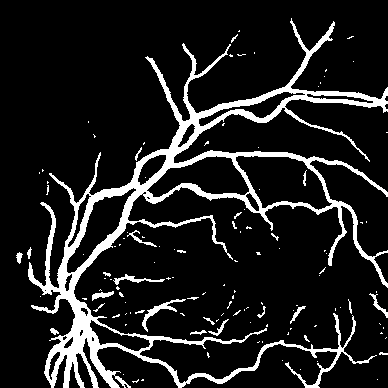

In [23]:
i = np.array(y_pred.reshape(-1, 388)*255, dtype=np.uint8)
IMG.fromarray(i)

In [ ]:
i = np.array(y_pred.reshape(-1, 565)*255, dtype=np.uint8)
IMG.fromarray(i)

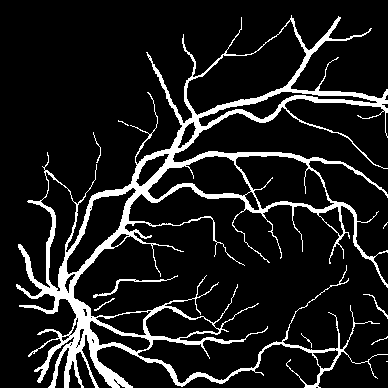

In [25]:
# IMG.fromarray(np.array(y_pred.reshape(584, 54/6)*255, dtype=np.uint8))
i = np.array(y_true.reshape(-1, 388)*255, dtype=np.uint8)
IMG.fromarray(i)

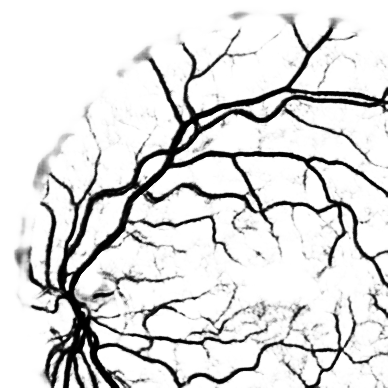

In [24]:
k = scores[:,1,:,:]
i = np.array(np.exp(k).reshape(-1, 388)*255, dtype=np.uint8)
IMG.fromarray(255-i)

In [37]:
# params = {'sk_threshold': 150,
#           'alpha': 7.0,
#           'orig_contrib': 0.3,
#           'seg_threshold': 24}

img_obj = SegmentedImage()

img_obj.load_file(data_dir=Dirs['images'], file_name='26_training.tif')
img_obj.res['orig'] = img_obj.image_arr[:, :, 1]
img_obj.working_arr = img_obj.image_arr[:, :, 1]

img_obj.load_mask(mask_dir=Dirs['mask'], fget_mask=get_mask_file, erode=True)
img_obj.load_ground_truth(gt_dir=Dirs['truth'], fget_ground_truth=get_ground_truth_file)

# img_obj.generate_skeleton(threshold=params['sk_threshold'])
# img_obj.generate_lattice_graph()

In [26]:
for i in testloader:
    break

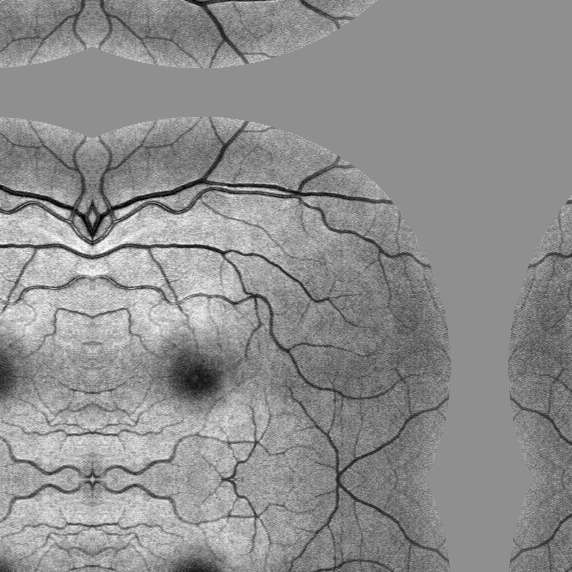

In [28]:
IMG.fromarray(np.array(i[0].squeeze()*255, dtype=np.uint8))

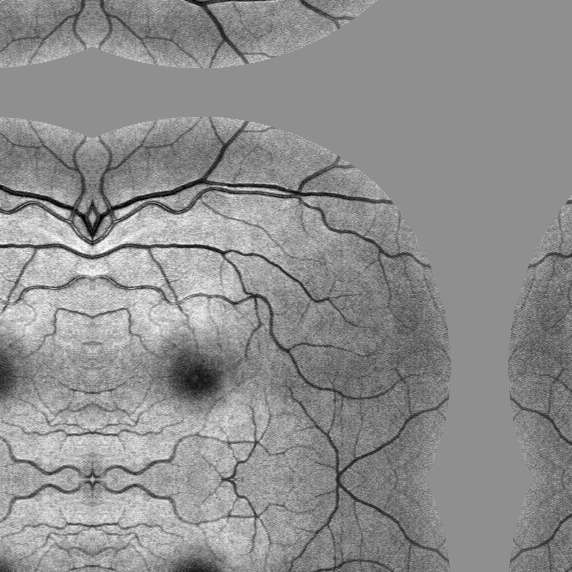

In [16]:
IMG.fromarray(np.array(i[0].squeeze()*255, dtype=np.uint8))

In [55]:
i[1].shape

torch.Size([1, 388, 388])